In [12]:
from pathlib import Path
import pandas as pd


classification_csv_path = Path("/Users/claudia/Desktop/Derma_Challenge/!!!!NoteBook/dateset/csv/clean_classification_dataset.csv")
df = pd.read_csv(classification_csv_path)


## Crear el dataset

El dataset utilizado en este proyecto se compone de imágenes recopiladas de la [Colaboración Internacional de Imágenes de Piel (ISIC)](https://challenge.isic-archive.com/).

In [13]:
# from ..datasets.classification_dataset import DermaClassificationDataset
from dateset.classification_dataset import  DermaClassificationDataset
import torchvision.transforms.v2 as transforms
import torch
from pathlib import Path

root_img_folder = Path("/Volumes/PortableSSD/dataset-clau/dataset_original/images")

basic_transforms = transforms.Compose(
    [
        transforms.Resize((512, 512), antialias=True),  # Redimensionar la imagen a 256x256
        # transforms.RandomCrop(224),  # Recorte aleatorio de 224x224
        # transforms.RandomRotation(30),  # Rotación aleatoria de hasta 30 grados
        # transforms.ToTensor(),  # Convertir la imagen a tensor
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        # transforms.Normalize(
        #     [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        # ),  # Normalización
    ]
)
df['metaclass'] = df['metaclass'].replace('Other', 'otros')

classification_dataset = DermaClassificationDataset(
    root_img_folder, image_dataframe=df, transform=basic_transforms
)

Exploremos que tan balanceadas están las clases en este dataset. Para esto vamos a utilizar el dataset de clasificación y crear un gráfico mostrando cuantas imágenes contiene cada clase.

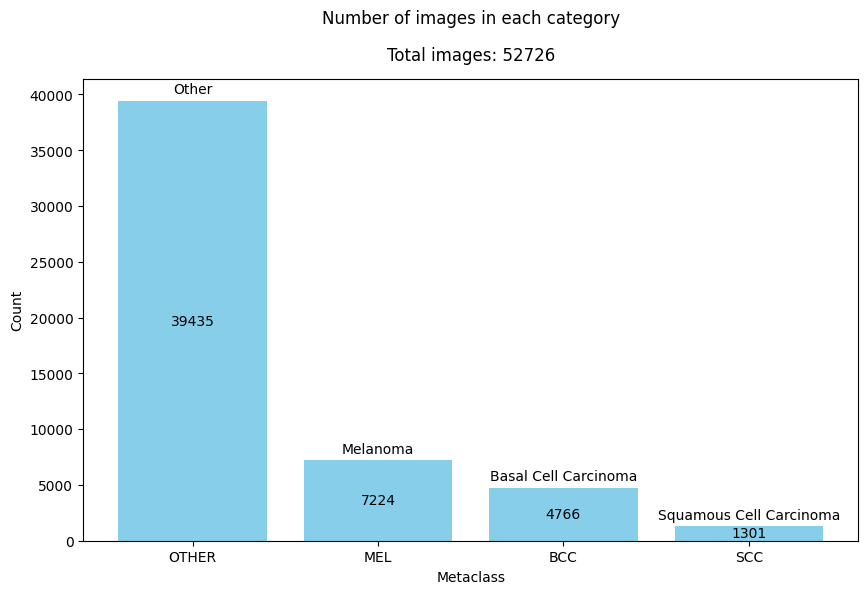

In [14]:
import matplotlib.pyplot as plt
from dateset.classification_dataset import  DermaClassificationDataset
import pandas as pd

classification_dataset.plot_class_distribution()


Como se puede observar el dataset se encuentra bastante desbalanceado. Solamente la categoría `OTHERS` contiene mas imágenes que la unión de las restantes categorías.

Para lidiar con el desbalance del dataset existen 3 estrategias comúnmente utilizadas:
- **Oversampling**: Esta técnica consiste en aumentar artificialmente el número de muestras de la clase minoritaria. Esto se puede hacer replicando las muestras existentes de la clase minoritaria o generando nuevas muestras sintéticas. Una de las técnicas más conocidas para generar nuevas muestras sintéticas es el algoritmo SMOTE (Synthetic Minority Over-sampling Technique). El objetivo del oversampling es equilibrar la distribución de clases para que el modelo no esté sesgado hacia la clase mayoritaria.
- **Undersampling**: Esta técnica reduce el número de muestras de la clase mayoritaria para equilibrar la distribución de clases. Aunque puede ser efectivo, el undersampling puede llevar a la pérdida de información valiosa, ya que se eliminan muestras de la clase mayoritaria.
- **Class Weighting**: Esta estrategia ajusta el peso de cada clase en la función de pérdida del modelo. Al asignar un mayor peso a la clase minoritaria y un menor peso a la clase mayoritaria, el modelo se entrena para prestar más atención a las muestras de la clase minoritaria. Esto ayuda a mitigar el sesgo hacia la clase mayoritaria y mejora la capacidad del modelo para predecir correctamente las muestras de la clase minoritaria. En PyTorch hay implementaciones de funciones de perdida que permiten especificar un peso de penalización a cada clase, ejemplo de esto es la clase `torch.nn.CrossEntropyLoss()` que tiene un parámetro `weight` que espera una lista con los valores de los pesos para cada una de las clases.

De estas estrategias nosotros vamos a emplear la técnica de oversampling utilizando inicialmente la clase `torch.utils.data.WeightedRandomSampler` en el `torch.utils.data.DataLoader` del dataset previamente creado, para que en un Epoch de entrenamiento se logren ver mas menos la misma cantidad de imágenes por cada categoría. El `WeightedRandomSampler` funciona definiendo *un peso para cada elemento* del dataset, en donde un peso mayor implica una mayor probabilidad de que ese elemento sea seleccionado en un batch. El peso que se le asignara a cada elemento es $1/len(category)$ donde `len(category)` representa la cantidad de elementos en la categoría

In [8]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm


def get_classification_train_dataloader(
    dataset: DermaClassificationDataset,
    batch_size: int = 32,
    num_workers: int = 4,
):
    """
    Creates a DataLoader for the DermaClassificationDataset with weighted sampling.

    Args:
        dataset (DermaClassificationDataset): The dataset to load.
        batch_size (int): The number of samples per batch.

    Returns:
        DataLoader: A DataLoader instance with weighted random sampling.
    """
    class_weights = dataset.get_categories_and_totals()
    sample_weights = [0] * len(dataset)

    # Instead of iterating over the dataset, we can use the labels directly from the dataframe
    series = dataset.image_df["metaclass"]
    for idx, label in tqdm(enumerate(series), total=len(series), colour="green"):
        label_num = dataset.metaclass_to_int(label)
        class_weight = class_weights[label_num]
        sample_weights[idx] = 1 / class_weight

    sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(sample_weights), replacement=True
    )
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    return loader


def get_default_dataloader(
    dataset: DermaClassificationDataset,
    batch_size: int,
    num_workers: int = 4,
):
    return DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)


def get_image_counts_by_category(dataloader):
    """
    Returns a dictionary with the count of images in each category from the given DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader to analyze.

    Returns:
        dict: A dictionary where each key is a category (as an integer) and the value is the total count of images in that category.
    """
    category_counts = {}

    # Iterate over the DataLoader
    for batch in tqdm(dataloader, leave=True):
        _, labels = batch

        # Iterate over the labels in the batch
        for label in labels:
            label = label.item()  # Convert tensor to integer
            if label in category_counts:
                category_counts[label] += 1
            else:
                category_counts[label] = 1

    return category_counts

### Probando el balanceo del dataset

In [7]:
import pandas as pd
from sklearn.utils import shuffle

def split_train_val(df, validation_split=0.2):
    # Verificar que el porcentaje de validación esté entre 0 y 1
    if not 0 <= validation_split <= 1:
        raise ValueError("validation_split debe estar entre 0 y 1")

    train_dfs = []
    val_dfs = []

    # Iterar sobre cada categoría
    for category in df['metaclass'].unique():
        # Obtener el subconjunto del DataFrame para la categoría actual
        category_df = df[df['metaclass'] == category]

        # Realizar un shuffle en el subconjunto
        category_df = shuffle(category_df, random_state=42)

        # Calcular el tamaño del conjunto de entrenamiento
        train_size = int((1 - validation_split) * len(category_df))

        # Dividir el subconjunto en entrenamiento y validación
        train_df = category_df.iloc[:train_size]
        val_df = category_df.iloc[train_size:]

        # Agregar los subconjuntos a las listas correspondientes
        train_dfs.append(train_df)
        val_dfs.append(val_df)

    # Unir los subconjuntos de entrenamiento y validación
    train_set = pd.concat(train_dfs).reset_index(drop=True)
    val_set = pd.concat(val_dfs).reset_index(drop=True)

    return train_set, val_set

train_set, val_set = split_train_val(df, validation_split=0.2)

train_proportions = train_set['metaclass'].value_counts(normalize=True)

# Calcular las proporciones de cada categoría en el conjunto de validación
val_proportions = val_set['metaclass'].value_counts(normalize=True)

# Comparar las proporciones
print("Proporciones en el conjunto de entrenamiento:")
print(train_proportions)

print("\nProporciones en el conjunto de validación:")
print(val_proportions)

# Verificar si las proporciones son similares
print("\nDiferencia en proporciones:")
print(train_proportions - val_proportions)


# DESCOMENTALO ESTA LA CANTIDAD

# print("Conjunto de entrenamiento:")
# other_examples = train_set[train_set['metaclass'] == 'OTHER']
# bcc_examples = train_set[train_set['metaclass'] == 'BCC']
# mel_examples = train_set[train_set['metaclass'] == 'MEL']
# scc_examples = train_set[train_set['metaclass'] == 'SCC']

# print("Ejemplos de validación de OTHER:")
# print(len(other_examples))

# print("\nEjemplos de validación de BCC:")
# print(len(bcc_examples))

# print("\nEjemplos de validación de MEL:")
# print(len(mel_examples))

# print("\nEjemplos de validación de SCC:")
# print(len(scc_examples))


# print("\nConjunto de validación:")

# other_val_examples = val_set[val_set['metaclass'] == 'OTHER']
# bcc_val_examples = val_set[val_set['metaclass'] == 'BCC']
# mel_val_examples = val_set[val_set['metaclass'] == 'MEL']
# scc_val_examples = val_set[val_set['metaclass'] == 'SCC']

# print("Ejemplos de validación de OTHER:")
# print(len(other_val_examples))

# print("\nEjemplos de validación de BCC:")
# print(len(bcc_val_examples))

# print("\nEjemplos de validación de MEL:")
# print(len(mel_val_examples))

# print("\nEjemplos de validación de SCC:")
# print(len(scc_val_examples))


Proporciones en el conjunto de entrenamiento:
metaclass
OTHER    0.747955
MEL      0.137011
BCC      0.090377
SCC      0.024657
Name: proportion, dtype: float64

Proporciones en el conjunto de validación:
metaclass
OTHER    0.747796
MEL      0.137006
BCC      0.090452
SCC      0.024746
Name: proportion, dtype: float64

Diferencia en proporciones:
metaclass
OTHER    0.000160
MEL      0.000006
BCC     -0.000076
SCC     -0.000090
Name: proportion, dtype: float64


In [17]:
import sys
import os
from pathlib import Path

# Agregar la ruta de la carpeta 'utils' al sys.path
utils_path = Path(os.path.abspath('../utils'))
if utils_path not in sys.path:
    sys.path.append(str(utils_path))

# Ahora puedes importar CacheImgFolder y ClassificationImgHelper
from cache_image_folder import CacheImgFolder
from graphic_tools import ClassificationImgHelper, ImgAxes

classification_cache = CacheImgFolder(
    root_image_folder=root_img_folder, cache_image_folder=Path("./cache/classification")
)
helper = ClassificationImgHelper(
    dataframe=df,
    get_category=lambda df, cat: df[df["metaclass"] == cat],
    get_image_path=lambda df: df["image_path"],
    cache=classification_cache,
)

In [21]:
helper.plot_random_sample_of_category(
    category="MEL",
    amount=9,
    resolution=(512, 512),
    dull_razor=True,
    fixed_axes=(ImgAxes.Column, 3),
    seed=5,
)

TypeError: CacheImgFolder.get_image_in_path() got an unexpected keyword argument 'dull_razor'